#FINAL PROJECT CODE
##TEAM: #26

**This Project consist of the following parts:**
1. Reading and Viewing Data drawings
2. Define Model training packages, helper functions and parameters
3. Prepare the training and validation input data
4. Build Basic Model architecture
5. Build our improve version of the DoodleNet model
6. Data Augmentation
7. Model Prediction

Download simplified data if need more data from link: https://drive.google.com/open?id=1iQ-GWMwGSl_Kd5WEK3aPUgHUh1BknT_m

Upload the simplified_train.zip to your google my drive in a directory (//My Drive/proj_data/input/..) you may have to create


Then mount your google drive to colab by running cell code below

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("/content/drive/My Drive/proj_data/input"))
print(os.listdir("/content/drive/My Drive/proj_data/input/train"))

big_data_path = "/content/drive/My Drive/proj_data/input/train_simplified.zip"

root_path ="/content/drive/My Drive/proj_data/drawings/"

train_path = "/content/drive/My Drive/proj_data/drawings/train/"
# train_path = "/content/drive/My Drive/proj_data/input/train2/"

valid_path = "/content/drive/My Drive/proj_data/input/test_simplified.zip"

# print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

['train', 'test_simplified.csv', 'train_simplified.zip', 'demo.csv', 'valid.csv', 'test.csv', 'test_ans.csv', 'output.csv', 'train2', '.ipynb_checkpoints']
['simplified_cat.ndjson', 'simplified_dog.ndjson', 'simplified_house.ndjson', 'simplified_roller coaster.ndjson']


In [0]:
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import ast
import math

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Let's read some of the training data

In [3]:
from zipfile import ZipFile

zip_file = ZipFile(big_data_path)

data = pd.read_csv(zip_file.open('roller coaster.csv'),
                   index_col=0,
                   nrows=10)[['drawing','word']]

header = list(data.columns.values.tolist()) 

data.head()

,drawing,word
countrycode,,
US,"[[[0, 28, 50, 73, 88, 94, 101, 101, 98, 100, 1...",roller coaster
US,"[[[0, 50, 78, 126, 142, 152, 157, 157, 141, 12...",roller coaster
US,"[[[2, 0, 17, 42, 68, 97, 120, 140, 151, 151, 1...",roller coaster
GB,"[[[192, 130, 101, 72, 0], [4, 99, 132, 148, 17...",roller coaster
US,"[[[9, 11, 19, 41, 114, 136, 153, 167, 179, 230...",roller coaster


### Fixing labels


In [5]:
data['word'] = data['word'].replace(' ', '_', regex=True)
data.head()

,drawing,word
countrycode,,
US,"[[[0, 28, 50, 73, 88, 94, 101, 101, 98, 100, 1...",roller_coaster
US,"[[[0, 50, 78, 126, 142, 152, 157, 157, 141, 12...",roller_coaster
US,"[[[2, 0, 17, 42, 68, 97, 120, 140, 151, 151, 1...",roller_coaster
GB,"[[[192, 130, 101, 72, 0], [4, 99, 132, 148, 17...",roller_coaster
US,"[[[9, 11, 19, 41, 114, 136, 153, 167, 179, 230...",roller_coaster


# Let's look at some images
We're going to grab the some images from the `demo.csv` file. Since the `word` values are read as a string, we need to convert them to a list using the `ast.literal_eval` function.

In [0]:
test_raw = pd.read_csv(zip_file.open('banana.csv'))
first_ids = test_raw.iloc[:5].index
images = [ast.literal_eval(lst) for lst in test_raw.loc[first_ids, 'drawing'].values]

## Viewing  Drawings

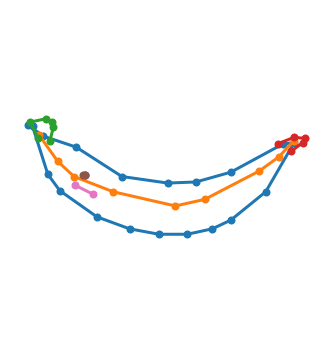

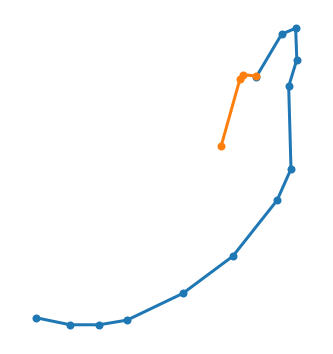

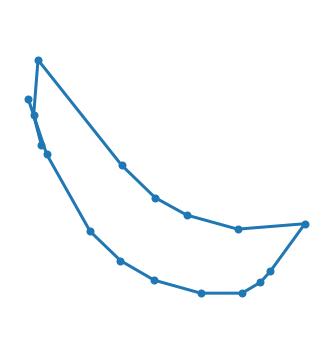

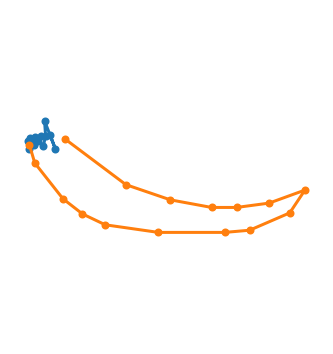

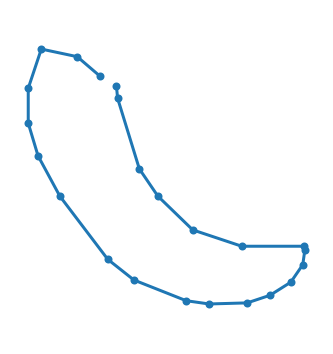

In [7]:
for index, drawing in enumerate(images, 0):
    
    plt.figure(figsize=(6,3))
    for x,y in drawing:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')


    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()  

# Define Model training packages, helper functions and parameters

In [4]:
import os
#  revise for mac os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [0]:
# required categories for this project
categories = [
  'whale','wine bottle','toaster','train','swan','spoon','snail','The Great Wall of China','roller coaster',
  'popsicle','rain','raccoon','key','fork','giraffe','marker','paintbrush','light bulb','door','cactus',
  'coffee cup','belt','bed','cake','laptop','bandage','bee','bear','banana','hand'
]

In [6]:
# define Model parameters
#/content/drive/My Drive/proj_data/drawings/train
class_paths = glob(train_path+'*.csv')
numstonames = {i: v[14:-4].replace(" ", "_").replace("/","").replace("My_Driveproj_datadrawingstrain", "") for i, v in enumerate(class_paths)}
print(numstonames)
namestonums = {v:k for k,v in numstonames.items()}

num_classes = 30
imheight, imwidth = 64, 64  
ims_per_class = 12000
valid_ims_per_class = 800
test_ims_per_class = 1


{0: 'wine_bottle', 1: 'toaster', 2: 'whale', 3: 'spoon', 4: 'train', 5: 'swan', 6: 'popsicle', 7: 'snail', 8: 'roller_coaster', 9: 'The_Great_Wall_of_China', 10: 'fork', 11: 'rain', 12: 'key', 13: 'raccoon', 14: 'giraffe', 15: 'door', 16: 'light_bulb', 17: 'marker', 18: 'paintbrush', 19: 'bed', 20: 'cactus', 21: 'belt', 22: 'coffee_cup', 23: 'bandage', 24: 'cake', 25: 'bee', 26: 'laptop', 27: 'bear', 28: 'banana', 29: 'hand'}


In [0]:
# define the draw function

def draw_it(strokes):
    image = Image.new("P", (64,64), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

# Prepare the training and validation input data

In [12]:
# extract and generate more data from a zip file "simplified_train.zip"  a data downloaded from kaggle
header =['','drawing', 'word']
train_df = pd.DataFrame(columns=header)
train_df = train_df.fillna(0) # with 0s rather than NaNs


for i, label in enumerate(tqdm(categories[0: num_classes])):
    train = pd.read_csv(zip_file.open(label+'.csv'),nrows=ims_per_class)[['drawing','word']]
    frames = [train_df, train]
    train_df = pd.concat(frames)
    train_df.to_csv('/content/drive/My Drive/proj_data/input/train2/'+label+'.csv')
    del train_df

  0%|          | 0/30 [00:00<?, ?it/s]


NameError: ignored

Preparing the train data set

In [8]:
train_grand = []

for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, nrows=ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
#less memory than np.concatenate
#del train
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) 
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

100%|██████████| 30/30 [02:57<00:00,  5.98s/it]


preparing the validation set

In [21]:

valid_grand = []
valid_df = pd.DataFrame(columns=header)
valid_df = valid_df.fillna(0) # with 0s rather than NaNs
#header =['countrycode','drawing','key_id', 'recognized', 'timestamp', 'word'] ## use this with bid data
header =['','drawing', 'word']


for i,label in enumerate(tqdm(class_paths[0: num_classes])):
    valid = pd.read_csv(label, skiprows=(ims_per_class+1), nrows=valid_ims_per_class )
    valid.columns=header
    # valid = valid[['drawing','word']]
    frames = [valid_df, valid]
    valid_df = pd.concat(frames)

valid_df.to_csv('valid.csv')

del valid

100%|██████████| 30/30 [00:14<00:00,  2.25it/s]


In [22]:
print(train_grand)

[[29.  1.  1. ...  1.  0.  0.]
 [29.  1.  1. ...  1.  1.  1.]
 [29.  1.  1. ...  1.  1.  1.]
 ...
 [ 0.  1.  1. ...  0.  0.  1.]
 [ 0.  1.  1. ...  1.  1.  1.]
 [ 0.  1.  1. ...  0.  0.  0.]]


Reshape, normalized and splits into X and Y train & validation sets 

In [0]:
np.random.shuffle(train_grand)
y_train, X_train = train_grand[:, 0], train_grand[:, 1:]

valid = pd.read_csv('/content/valid.csv',nrows = ims_per_class)
imagebag = bag.from_sequence(valid.drawing.values).map(draw_it)
validarray = np.array(imagebag.compute())
validarray = np.reshape(validarray, (validarray.shape[0], imheight, imwidth, 1))


X_val = validarray
y_val = [namestonums[w.replace(" ", "_") ] for w in valid.word]

# del train_grand
del validarray

# Reshape and normalize
y_train = keras.utils.to_categorical(y_train, num_classes)
x_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1).astype('float32')
y_val = keras.utils.to_categorical(y_val, num_classes)
x_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1).astype('float32')

del X_train
x_train /= 127.5
x_val /= 127.5

#Build Basic Model architecture

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________

In [0]:
import time
starttime = time.time()

Train (fit) the model

In [0]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5) 
callbacks = [reduceLROnPlat, earlystop]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

H1 = model.fit(x=x_train, y=y_train,
          batch_size = 32,
          epochs = 50,
          validation_split=0.05,
          #validation_data = (x_val, y_val),
          callbacks = callbacks,
          verbose = 1)
endtime = time.time()

Train on 228000 samples, validate on 12000 samples
Epoch 1/50
228000/228000 [==============================] - 76s 333us/sample - loss: 2.5864 - acc: 0.2693 - top_3_accuracy: 0.4840 - val_loss: 2.4637 - val_acc: 0.2973 - val_top_3_accuracy: 0.5083
Epoch 2/50
228000/228000 [==============================] - 69s 305us/sample - loss: 2.3857 - acc: 0.3204 - top_3_accuracy: 0.5438 - val_loss: 2.3921 - val_acc: 0.3055 - val_top_3_accuracy: 0.5383
Epoch 3/50
228000/228000 [==============================] - 70s 306us/sample - loss: 2.3084 - acc: 0.3402 - top_3_accuracy: 0.5658 - val_loss: 2.3155 - val_acc: 0.3368 - val_top_3_accuracy: 0.5556
Epoch 4/50
228000/228000 [==============================] - 70s 308us/sample - loss: 2.2598 - acc: 0.3528 - top_3_accuracy: 0.5787 - val_loss: 2.2798 - val_acc: 0.3440 - val_top_3_accuracy: 0.5765
Epoch 5/50
228000/228000 [==============================] - 70s 306us/sample - loss: 2.2165 - acc: 0.3640 - top_3_accuracy: 0.5902 - val_loss: 2.2724 - val_acc: 

In [0]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save(root_path+'basic_classifier_model.h5') 

dict_keys(['loss', 'acc', 'top_3_accuracy', 'val_loss', 'val_acc', 'val_top_3_accuracy', 'lr'])


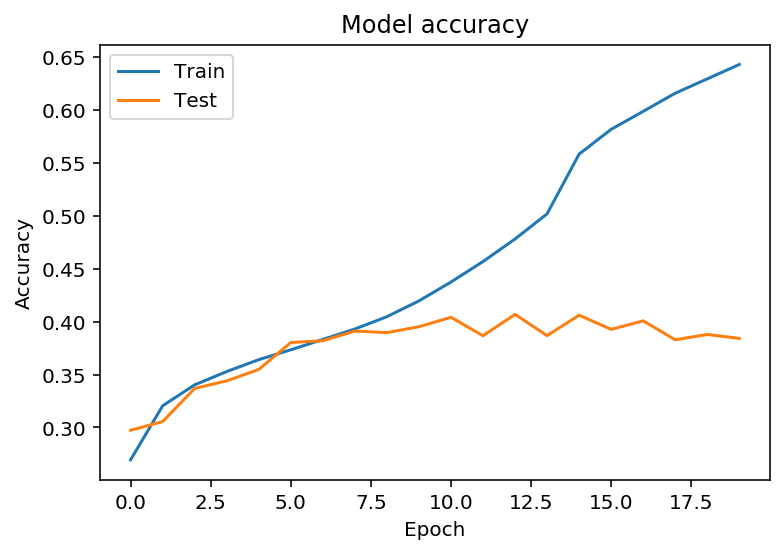

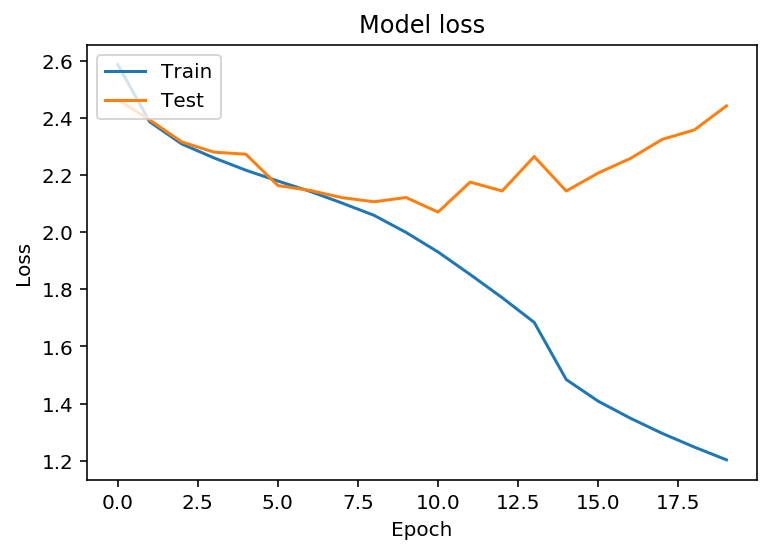

In [0]:
# list all data in history
print(H1.history.keys())
# summarize history for accuracy
plt.plot(H1.history['acc'])
plt.plot(H1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(H1.history['loss'])
plt.plot(H1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Build our improve version of the DoodleNet model

In [0]:
# DoodleNet model
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [26]:
print(len(x_train))
print(len(y_train))

# Define model layers
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3), padding='same', input_shape=x_train.shape[1:], use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Convolution2D(16, (3, 3), padding='same', input_shape=x_train.shape[1:], use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Convolution2D(32, (3, 3), padding='same', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Convolution2D(32, (3, 3), padding='same', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Convolution2D(64, (3, 3), padding='same', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Convolution2D(64, (3, 3), padding='same', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size =(2,2)))

model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(num_classes, activation='softmax')) 

adam = tf.keras.optimizers.Adam(lr=0.001)
# adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy','top_k_categorical_accuracy'])
print(model.summary())

360000
360000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        144       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2304      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
___________________________

In [27]:
H3 = model.fit(x = x_train, y = y_train, validation_split=0.02, batch_size = 256, verbose=2, epochs=20)

Train on 352800 samples, validate on 7200 samples
Epoch 1/20
352800/352800 - 58s - loss: 2.4121 - acc: 0.3132 - top_k_categorical_accuracy: 0.6492 - val_loss: 2.2903 - val_acc: 0.3422 - val_top_k_categorical_accuracy: 0.6810
Epoch 2/20
352800/352800 - 52s - loss: 2.1770 - acc: 0.3691 - top_k_categorical_accuracy: 0.7083 - val_loss: 2.1936 - val_acc: 0.3761 - val_top_k_categorical_accuracy: 0.6978
Epoch 3/20
352800/352800 - 53s - loss: 2.0549 - acc: 0.4010 - top_k_categorical_accuracy: 0.7347 - val_loss: 2.0800 - val_acc: 0.3940 - val_top_k_categorical_accuracy: 0.7331
Epoch 4/20
352800/352800 - 51s - loss: 1.9600 - acc: 0.4253 - top_k_categorical_accuracy: 0.7522 - val_loss: 3.2039 - val_acc: 0.2558 - val_top_k_categorical_accuracy: 0.5617
Epoch 5/20
352800/352800 - 51s - loss: 1.8943 - acc: 0.4430 - top_k_categorical_accuracy: 0.7654 - val_loss: 2.0152 - val_acc: 0.4144 - val_top_k_categorical_accuracy: 0.7406
Epoch 6/20
352800/352800 - 52s - loss: 1.8351 - acc: 0.4571 - top_k_categor

In [0]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save(root_path+'doodlenet_classifier_model.h5') 

dict_keys(['loss', 'acc', 'top_k_categorical_accuracy', 'val_loss', 'val_acc', 'val_top_k_categorical_accuracy'])


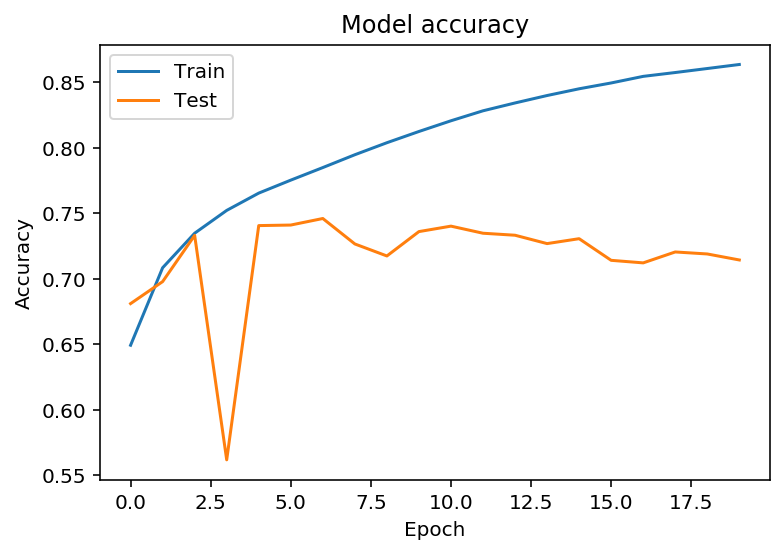

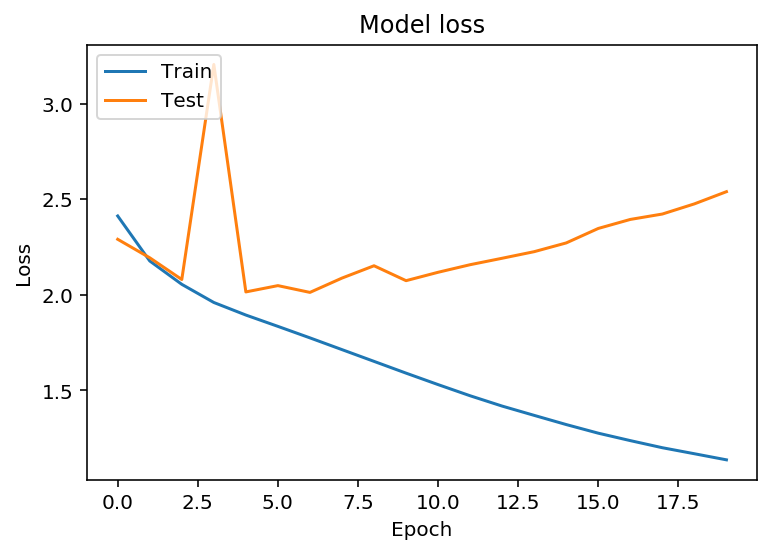

In [28]:
# list all data in history
print(H3.history.keys())
# summarize history for accuracy
plt.plot(H3.history['top_k_categorical_accuracy'])
plt.plot(H3.history['val_top_k_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(H3.history['loss'])
plt.plot(H3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Data Augmentation

In [52]:
# # more kinds of augmentation can be found at https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator # for data augmentation


Using TensorFlow backend.


In [0]:
# initialize the number of epochs and batch size
EPOCHS = 40
BS = 32
 
# construct the training image generator settings for data augmentation
aug = ImageDataGenerator(rotation_range=5,  
                         zoom_range=0.15,
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15,
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [0]:
import time
starttime = time.time()

In [57]:
# train the network with the augmented training data patches 
H2 = model.fit_generator(aug.flow( x_train, y_train, batch_size=BS), 
                        validation_data=(X_val, y_val),
                        #validation_split=0.05, 
                        steps_per_epoch=len(x_train) // BS,
                        epochs=EPOCHS,
                        #callbacks = callbacks,
                        verbose = 1)

Epoch 1/40
 1156/11250 [==>...........................] - ETA: 2:56 - loss: 3.4340 - acc: 0.1679 - top_k_categorical_accuracy: 0.4709

KeyboardInterrupt: ignored

In [0]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save(root_path+'augDoodleNet_classifier_model.h5') 

Create visual chart of the augmented training metrics

dict_keys(['loss', 'acc', 'top_k_categorical_accuracy', 'val_loss', 'val_acc', 'val_top_k_categorical_accuracy'])


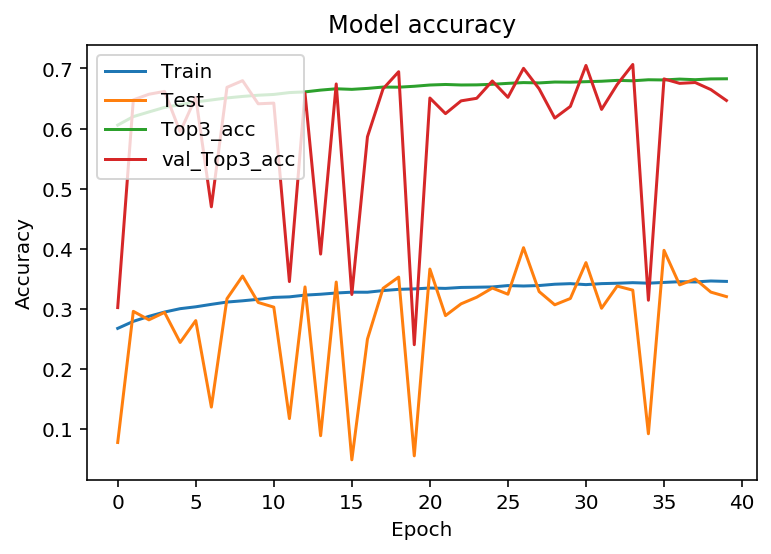

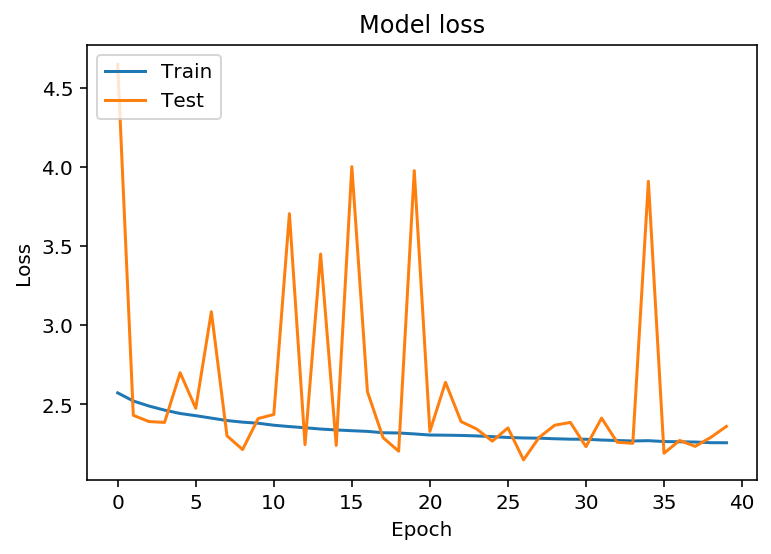

In [52]:
# list all data in history
print(H2.history.keys())
# summarize history for accuracy
plt.plot(H2.history['acc'])
plt.plot(H2.history['val_acc'])
plt.plot(H2.history['top_k_categorical_accuracy'])
plt.plot(H2.history['val_top_k_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test', 'Top3_acc', 'val_Top3_acc'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(H2.history['loss'])
plt.plot(H2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Load and recreate the model from save h5 file:



In [48]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model(root_path+'augDoodleNet_classifier_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 16)        144       
_________________________________________________________________
batch_normalization_12 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
activation_12 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)        2304      
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
activation_13 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)       

In [49]:
# check it accuracy
loss, acc, top_k_categorical_accuracy = new_model.evaluate(X_val,  y_val, verbose=1)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))


8000/8000 [==============================] - 1s 130us/sample - loss: 2.3606 - acc: 0.3204 - top_k_categorical_accuracy: 0.6466
Restored model, accuracy: 32.04%


# Model Prediction

In [0]:
test = pd.read_csv(root_path+'demo.csv')[['drawing']]
imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
testarray = np.array(imagebag.compute())
testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
testpreds = model.predict(testarray, verbose=0)
ttvs = np.argsort(-testpreds)

In [18]:
for idx in ttvs[:,[0,1,2]]:
    print(numstonames[idx[0]])
    print(numstonames[idx[1]])
    print(numstonames[idx[2]])
    print('----------')

banana
swan
giraffe
----------
cactus
bee
whale
----------
banana
swan
giraffe
----------
fork
paintbrush
wine_bottle
----------
wine_bottle
laptop
door
----------


## Preprocessing the generating data and predict

In [19]:
graph = pd.read_csv(os.path.join(root_path,'output.csv'),header=None)
grapharray = np.array(graph)
grapharray = np.where(grapharray[:] > 0.2,1,0)
grapharray = np.reshape(grapharray, (1,imheight, imwidth, 1))
graphpreds = model.predict(grapharray, verbose=0)
gvs = np.argsort(-graphpreds)


for idx in gvs[:]:
    for i in idx:
        print(numstonames[i])


bear
cake
bandage
roller_coaster
bee
light_bulb
paintbrush
belt
rain
cactus
raccoon
whale
bed
giraffe
train
snail
swan
spoon
The_Great_Wall_of_China
banana
laptop
wine_bottle
key
marker
door
toaster
popsicle
coffee_cup
fork
hand


## Making a Submission

In [0]:
test = pd.read_csv(root_path+'test.csv')[['drawing']]
imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
testarray = np.array(imagebag.compute())
testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
testpreds = model.predict(testarray, verbose=0)
ttvs = np.argsort(-testpreds)



predict_label = [numstonames[ttvs[i][0]] for i in range(ttvs.shape[0])]

test['word'] = predict_label
test.to_csv(root_path+'test_predict.csv')